# Hoboken Block by Block

A work in progress, this project was inspired by a joke my friend made - that resident age in Hoboken increases the farther you get from the Hoboken Train Station (located in the southeast of the city). As a scientist, I wanted to see if there was empirical evidence for this human intuition. 

In this notebook I will import raw data on the population of Hoboken, NJ from the 2010 Cenus. Then convert this data into an easy-to-use pandas dataframe. I will then plot the median population of each block to their 2D latitude and longitude coordinates.

## What data to use
The best-known dataset from the US Census Bureau is, of course, the 10-year census. This survey collects demographic data on all Americans at every address in the country. The data is released to the public is given down to level of a city block. This is most detailed dataset geographically. 

The most recent census was in 2010 and may not be completely accurate relection of Hoboken today. For one thing, Hurricane Sandy hit Hoboken hard in 2012 and while the city has bounced back since then, it certainly had an enormous impact on residents and on building projects. For another, 2010 was not long after the Great Recession of 2008. Economic prospects were uncertain and this certainly would impact who could afford to live in Hoboken. Recent college grads had trouble starting their careers and older retirees worried if their investments were enough to retire anymore.

More recent data can be found in the American Community Survey (ACS). Each year, the ACS collects detailed data on participants such as health, income, commuting distance, and more. Because of the implementation of the ACS, the 2010 census collected only board demographic data on respondents - age, race, household type, etc. The ACS provides much more update information about Hoboken today, however it only provides data down to the level of census tract. 

Hoboken is made up 195 census blocks grouped into 14 census tracts. For this project, I wanted as detailed geographical data as I can find, so I decided to use data from the 2010 census.

In [1]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
from bs4 import BeautifulSoup

%matplotlib inline

## Mining population data from the 2010 Census
We start by importing data via the US Census Bureau's API. 

https://geomap.ffiec.gov/FFIECGeocMap/GeocodeMap1.aspx  - useful for finding state, country, and tract codes for your desired location.
https://www2.census.gov/geo/maps/dc10map/GUBlock/st34_nj/county/c34017_hudson/DC10BLK_C34017_008.pdf  - map of numbered blocks in Hoboken.
https://api.census.gov/data/2010/sf1/variables.html - description of variable names in the 2010 US Census data set.
https://api.census.gov/data/2010/sf1/examples.html - examples of using the API to get Census data.

We will be importing data for in Hudson County, NJ. Block by block, we will import:
- total polutation (P0010001)
- the median age for both sexes (P0130001)
- the median age for males (P0130002) 
- the median age for females (P0130003)
- the number of household (P0180001)
- the number of family households (P0180002)


In [2]:
parameters = {"get": "P0010001,P0130001,P0130002,P0130003,P0180001,P0180002,ZCTA5", 
             "for": "block:*", 
             "in": "state:34 county:017"}
r = requests.get("https://api.census.gov/data/2010/sf1", params = parameters)
example = "?get=P0010001,P0030001&for=zip%20code%20tabulation%20area:07030&in=state:34"
example2 = "https://api.census.gov/data/2010/sf1?get=P0010001,P0030001&for=block%20group:*&in=state:02%20county:170&key=YOUR_KEY_GOES_HERE"
print(r)
print(r.url) # sanity check

<Response [200]>
https://api.census.gov/data/2010/sf1?get=P0010001%2CP0130001%2CP0130002%2CP0130003%2CP0180001%2CP0180002%2CZCTA5&for=block%3A%2A&in=state%3A34+county%3A017


## Wrangling population data

The census API makes wrangling data a fairly simple process. The data is a table coded as a .json file, we can convert it easily into a pandas dataframe for easier manipulation. We also change the names of each column from the standard census designation "P#######" to human-friendly labels.

In [3]:
data_raw = r.json()
print(type(data_raw))
data = pd.DataFrame(data_raw[1::], columns = data_raw[0])
data = data.rename({'P0010001': 'Population', 
                            'P0130001': 'Median_Age', 
                            'P0130002': 'Male_Age', 
                           'P0130003': 'Female_Age', 
                           'P0180001': 'Households', 
                           'P0180002': 'Families'}, 
                           axis='columns')
data[["Population", "Median_Age", "Male_Age", "Female_Age", "Households", "Families"]] = data[["Population", "Median_Age", "Male_Age", "Female_Age", "Households", "Families"]].apply(pd.to_numeric)


<class 'list'>


Now we collected data on the entirety of Hudson county, but we really just want to know anout Hoboken. We select out this data using the Hoboken zip code - 07030. 
After selecting data from the Hoboken zip code, we no longer need to store that information since it will be the same for all entries. Likewise the state and country infromation is redundant. We drop those columns and reset the index values for convenience and print our final dataframe.

In [4]:
Hob_data = data[data.ZCTA5=='07030'].drop(columns=['state', 'county', 'ZCTA5'])
Hob_data = Hob_data[Hob_data.Population > 0].reset_index(drop=True)
Hob_data

,Population,Median_Age,Male_Age,Female_Age,Households,Families,tract,block
0,784,34.3,34.7,33.8,399,221,018301,1001
1,921,31.6,32.0,31.1,474,206,018301,2002
2,84,35.8,38.0,33.5,42,23,018301,2003
3,3,28.5,41.5,27.5,2,1,018301,2004
4,10,42.5,48.5,42.3,0,0,018301,2006
5,428,33.6,35.0,32.3,229,96,018302,1001
6,1011,33.1,33.0,33.1,558,245,018302,1002
7,2,53.0,52.5,53.5,1,1,018302,1004
8,41,35.5,36.3,34.0,22,10,018302,1005
9,2,39.0,52.5,25.5,1,1,018302,1006


## Mining block location data

We have our population data but not the spacial location of popultion. For that we use the US Census Gazeeter data. This gives the latitude, longitude and some other size data for various locations in the US. The Census Bureau stores this information for mapmaking purposes and it can be found on their TIGERweb site. The site has a variety of different datasets from the national level down to state and county. The site with block data for Hudson County, NJ is:
https://tigerweb.geo.census.gov/tigerwebmain/Files/tab10/tigerweb_tab10_tabblock_2010_nj_017.html

In [7]:
url = "https://tigerweb.geo.census.gov/tigerwebmain/Files/tab10/tigerweb_tab10_tabblock_2010_nj_017.html"
Hudson_coords = pd.read_html(url, header=0)[0]
Hudson_coords

,MTFCC,OID,GEOID,STATE,COUNTY,TRACT,BLKGRP,BLOCK,BASENAME,NAME,...,FUNCSTAT,POP100,HU100,AREALAND,AREAWATER,UR,CENTLAT,CENTLON,INTPTLAT,INTPTLON
0,G5040,210403968173643,340170001001000,34,17,100,1,1000,1000,Block 1000,...,S,0,0,42208,0,U,40.758581,-74.053211,40.758581,-74.053211
1,G5040,210403968173652,340170001001001,34,17,100,1,1001,1001,Block 1001,...,S,116,44,15039,0,U,40.759143,-74.051212,40.759143,-74.051212
2,G5040,210403968173650,340170001001002,34,17,100,1,1002,1002,Block 1002,...,S,268,83,15040,0,U,40.758785,-74.050435,40.758785,-74.050435
3,G5040,210403968174360,340170001001003,34,17,100,1,1003,1003,Block 1003,...,S,183,63,12898,0,U,40.758273,-74.049695,40.758273,-74.049695
4,G5040,210403968173658,340170001001004,34,17,100,1,1004,1004,Block 1004,...,S,402,131,28339,0,U,40.756377,-74.050911,40.756377,-74.050911
5,G5040,210403968173645,340170001001005,34,17,100,1,1005,1005,Block 1005,...,S,333,129,26018,0,U,40.756694,-74.051806,40.756694,-74.051806
6,G5040,210403968173647,340170001001006,34,17,100,1,1006,1006,Block 1006,...,S,326,116,26483,0,U,40.756991,-74.052685,40.756991,-74.052685
7,G5040,210403968173646,340170001001007,34,17,100,1,1007,1007,Block 1007,...,S,94,35,23929,0,U,40.757491,-74.053268,40.757491,-74.053268
8,G5040,210403968174561,340170001001008,34,17,100,1,1008,1008,Block 1008,...,S,195,65,28649,0,U,40.754759,-74.055312,40.754759,-74.055312
9,G5040,210403968170972,340170001001009,34,17,100,1,1009,1009,Block 1009,...,S,0,0,27840,0,U,40.754952,-74.056416,40.754952,-74.056416


Recall that once again this data is for the entirety of Hudson County. We only want the Hoboken data, but this time there is no zip code information to easily pull the blocks in Hoboken. Instead, each block is identifiable by its tract and block number. I find the indexes of block in Hoboken using the Hoboken population dataset (`Hob_data`) to identify tract and block numbers. I store these indexes in the list `ind` and use it to build a dataframe `Hob_coords` with lat, long, and area data for each block in Hoboken. I then combine the population data and geographic data into one unified dataframe.

In [8]:
ind = []
for i in range(0,Hob_data.shape[0]):
    tract = int(Hob_data.tract[i])
    block = int(Hob_data.block[i])
    ind.append(np.array(Hudson_coords.TRACT==tract) & np.array(Hudson_coords.BLOCK==block))

Hob_coords = Hudson_coords[ind[0]][["CENTLAT", "CENTLON", "AREALAND"]]
for i in range(1,len(ind)):
    Hob_coords = Hob_coords.append(Hudson_coords[ind[i]][["CENTLAT", "CENTLON","AREALAND"]],ignore_index=True)

All_data = pd.concat([Hob_data, Hob_coords], axis=1, sort=False)
All_data

,Population,Median_Age,Male_Age,Female_Age,Households,Families,tract,block,CENTLAT,CENTLON,AREALAND
0,784,34.3,34.7,33.8,399,221,018301,1001,40.748905,-74.024076,80068
1,921,31.6,32.0,31.1,474,206,018301,2002,40.740127,-74.027394,12118
2,84,35.8,38.0,33.5,42,23,018301,2003,40.738842,-74.027724,13738
3,3,28.5,41.5,27.5,2,1,018301,2004,40.737558,-74.028086,14461
4,10,42.5,48.5,42.3,0,0,018301,2006,40.734572,-74.028514,64113
5,428,33.6,35.0,32.3,229,96,018302,1001,40.753020,-74.022960,80722
6,1011,33.1,33.0,33.1,558,245,018302,1002,40.754724,-74.025319,13379
7,2,53.0,52.5,53.5,1,1,018302,1004,40.755862,-74.027367,31493
8,41,35.5,36.3,34.0,22,10,018302,1005,40.754051,-74.027133,10345
9,2,39.0,52.5,25.5,1,1,018302,1006,40.754239,-74.028080,12480


## The Age Distibution of Hobokenites

Let's look at a histogram of the median ages for all blocks we've collected to get a sense of the age distribution of Hobokenites.

Now, this data not by any means give the full picture. Each count represents one *block* rather than 1 person and blocks have varying population. It also is the median age for the block, we don't know anything about the age distribution within each block. But it is a start.

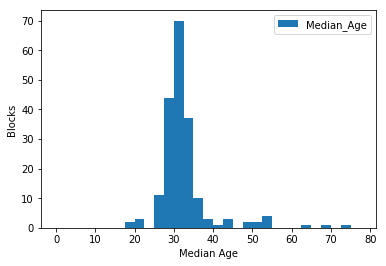

In [58]:
Hob_data[["Median_Age"]].plot.hist(bins = np.arange(0,80,2.5),density=False)
plt.xlabel("Median Age");
plt.ylabel("Blocks");

Based on this 2010 data we gather that:
- Most residents are in the age range of 25-38 and few residents under 25 or over 40.
- There is a small population ~20 years old who are likely students at Stevens Institute of Technology, a college here in the city.
- There is also a small population in their early 50s. Are these Hoboken natives who grew up in the city and never left? Or empty-nesters from the suburbs who have downsized and are enjoying city life?

## Geographical Distibution of Hobokenites by Age

Now to look at where residents of different ages actually live in the city. One way to do this is a scatter plot. Each point represents one block and its x,y coordiates will be the longitude, latitude of that block. We then color each point by median age of that block. And to add some population density information we can also size the points by the total number of residents.

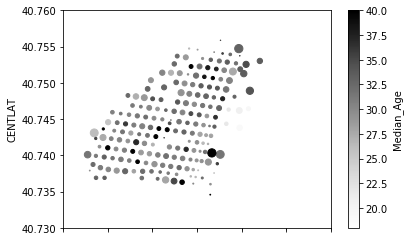

In [59]:
ax1 = All_data.plot.scatter(x='CENTLON', y='CENTLAT', c='Median_Age', 
                            s=All_data.Population/15,vmin=18, vmax=40);
ax1.set_ylim(40.73,40.76)
ax1.set_xlim(-74.045,-74.015);

This is pretty cool looking! But a little too detailed to make much sense of.

For a bigger picture, let's find the median age over larger areas of Hoboken and plot it in a similar way. For this we use `hexbin` to make a 2D color-coded map of Hoboken. Each hexogon covers multiple blocks and plots the mean of the `Median_Age` of the blocks within it.

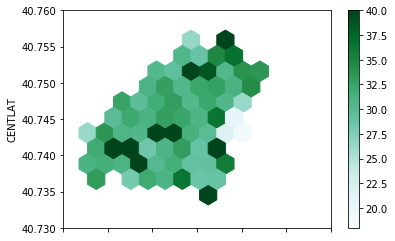

In [60]:
ax2 = All_data.plot.hexbin(x='CENTLON', y='CENTLAT', C='Median_Age', 
                           gridsize=10, vmin=18, vmax=40);
ax2.set_ylim(40.73,40.76)
ax2.set_xlim(-74.045,-74.015);


This is a little clearer. We can see a cluster of 20-year-olds on the east side where Stevens is. The original hypothesis was that age of residents is lowest in the southeast of the city and increases as you move away. This figure shows a more complex distribution of ages around the city, with pockets of old and young scattered around.

## What about families?

Our plots are based on the median age on each block, but, as mentioned, this does not give a full picture. A lot of families live Hoboken and the presence of young children on a block could create a multimodal age distribution for the block they live on which is not well characterized by a simple median. So let's look at the geographical distribution of families within the city.

Our dataset does include information on the number families on each block as well as the total number of household (whether the household is a family or not). We use this data to create a new column in our dataframe for the percent of all households that are families and make another scatterplot, this time showing the blocks have the greatest propotion of families.

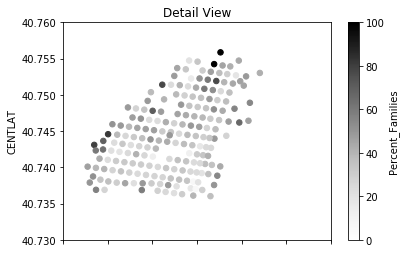

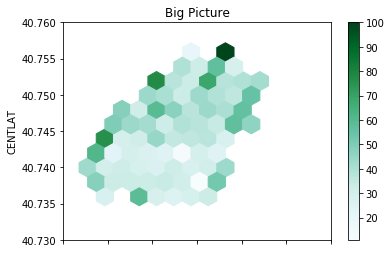

In [84]:
All_data['Percent_Families'] = pd.Series(100*All_data.Families/All_data.Households,index=All_data.index)
ax1 = All_data.plot.scatter(x='CENTLON', y='CENTLAT', c='Percent_Families',s=30);
plt.title("Detail View")
ax1.set_ylim(40.73,40.76)
ax1.set_xlim(-74.045,-74.015);

ax2 = All_data.plot.hexbin(x='CENTLON', y='CENTLAT', C='Percent_Families', gridsize=10);
plt.title("Big Picture")
ax2.set_ylim(40.73,40.76)
ax2.set_xlim(-74.045,-74.015);

Here the trends are more clear than the map of median age. Blocks to the west and north tend to have more families than those is in the southeast. This map also suggests the observations that lead to the original hypothesis: Older residents have families and live with their kids away from the more commercially developed southeast of the city. Young 20-somethings want to live close to the bars and train into New York City.

## Future Plans

While, as discussed, the median age data gives a limited view, the census does provide data on the number of people in each age-groups on each block (25-30, 30-35, etc.). Going forward I would like independently geographic distribution of people in each age group. This would definitively tell us whether 20-somethings cluster in particular areas vs. 30-somethings.

I'd like to use this information to create a predictive model that incorporates age, household type, and other factors to predict where in the city a individual lives.